# AI Community @ Семинар № 2
## TF-IDF
Данные тут: https://archive.ics.uci.edu/ml/machine-learning-databases/00233/

### Введение
TF-IDF - технология NLP, Information Retrieval и Data Mining для анализа классифицированных датасетов, показывающая насколько слово важно для класса (документа)

TF-IDF - Term Frequency - Inverted Document Frequency

**Term Frequency** - $tf(t,d)$ - насколько часто терм $t$ встречается в документе $d$  
**Inverted Document Frequency** - $idf(t,D)$ - насколько терм $t$ значим для документа в датасете $D$. Пример: если в новости есть слово "Путин", то новость скорее всего про политику, а если там есть слово "он", то категория может быть любая.


Варианты вычисления $tf(t,d)$:
1. $tf(t,d)$ = 1 или 0 (есть терм в документе или нет)
1. $tf(t,d) = с_{t,d}$ (количество упоминаний терма в документе)
1. $tf(t,d) = \frac{с_{t,d}}{\sum_{t'}с_{t,d}}$ (частота упоминания терма в документе)
1. $tf(t,d) = 1 + \log с_{t,d}$ (лог-нормализация)

Варианты вычисления $idf(t,D)$:
1. $idf(t,D) = 1$ (все слова одинаково репрезентативны)
2. $idf(t,D) = -\log \frac{n_t}{N}$, $n_t$ - количество документов, в которых встретился терм $t$
2. $idf(t,D) = \log (1+\frac{N}{n_t})$, $n_t$ - то же самое, но сглаженное (никогда не 0) 

Теперь мы можем определить "ценность" терма для документа как 

$$tfidf(t,d,D) = tf(t,d)\cdot idf(t,D)$$


### Пример для задачи классификации

In [100]:
import numpy as np
from glob import glob
import nltk
stemmer = nltk.SnowballStemmer('english')
from nltk.corpus import stopwords
from nltk.corpus import reuters
sw = stopwords.words('english')
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from tqdm import tqdm
import re
regexp = re.compile('[a-z]+')

In [105]:
cats_joined = dict()
for f_id in tqdm(reuters.fileids()):
    cat = reuters.categories(f_id)[0]      
    words = [stemmer.stem(word.lower()) for word in reuters.words(f_id) if len(word) > 2 and regexp.match(word)]
    if cat in cats_joined:
        cats_joined[cat] += ' '.join(words)
    else:
        cats_joined[cat] = ' '.join(words)
cats_list = [cats_joined[key] for key in sorted(cats_joined)]

100%|██████████| 10788/10788 [00:15<00:00, 705.74it/s]


In [106]:
tfidf_vectorizer = TfidfVectorizer(min_df=3,
                                   max_features=2000,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(cats_joined.values())

Тут лежат слова, индексы соответствуют столбцам матрицы

In [133]:
best_words = tfidf_vectorizer.get_feature_names()

Тут лежат категории, индексы соответствуют столбцам матрицы

In [109]:
categories = sorted(cats_joined)

А это сама матрица

In [127]:
tfidf = tfidf.toarray()

Посмотрим слова, соответствующие категории "какао"

In [198]:
i = 6
print(categories[i])
np.array(best_words)[np.argsort(tfidf[i])][-5:]

cocoa


array(['bag', 'export', 'said', 'quota', 'coffe'], 
      dtype='<U13')

### Latent semantic analysis (Латентно-семантический анализ)
Задача: определить, похожи ли два терма или два документа друг на друга  
Идея: Похожие документы характеризуются похожими словами 

Обозначим матрицу TF-IDF как $X$
Определим похожесть термов $i$ и $j$ как $c_i^Tc_j$, где $c_i$ - столбец матрицы $X$, соответствующий терму $i$.
Тогда $X^TX$ будет содержать все возможные пары похожих слов

Известно, что для любой матрицы существует SVD-разложение:  
$$X = U \Sigma V^T$$
Где $\Sigma$ - диагональная матрица, $U$,$V$ - ортогональные матрицы ($UU^T=U^TU=I$).
Тогда $$X^TX = V \Sigma^T U^T U \Sigma V^T = V \Sigma^T \Sigma V^T$$
Отсюда $X = \Sigma V^T$

Всё ещё вычислительно трудно.

Но в $\Sigma$ может быть определённое количество близких к нулю значений, они почти не влияют на матрицу. Поэтому можно приблизить $V \Sigma^T \Sigma V^T$ как $V_k \Sigma_k^T \Sigma_k V_k^T$, где индекс $k$ означает, что мы берём строки/столбцы, соответствующие $k$ наибольшим значениям матрицы $\Sigma$


In [202]:
from sklearn.decomposition import TruncatedSVD

In [205]:
tsvd = TruncatedSVD(n_components=2)
ans = tsvd.fit_transform(tfidf)

In [207]:
ans.shape

(79, 2)

In [208]:
%matplotlib inline
import matplotlib.pyplot as plt

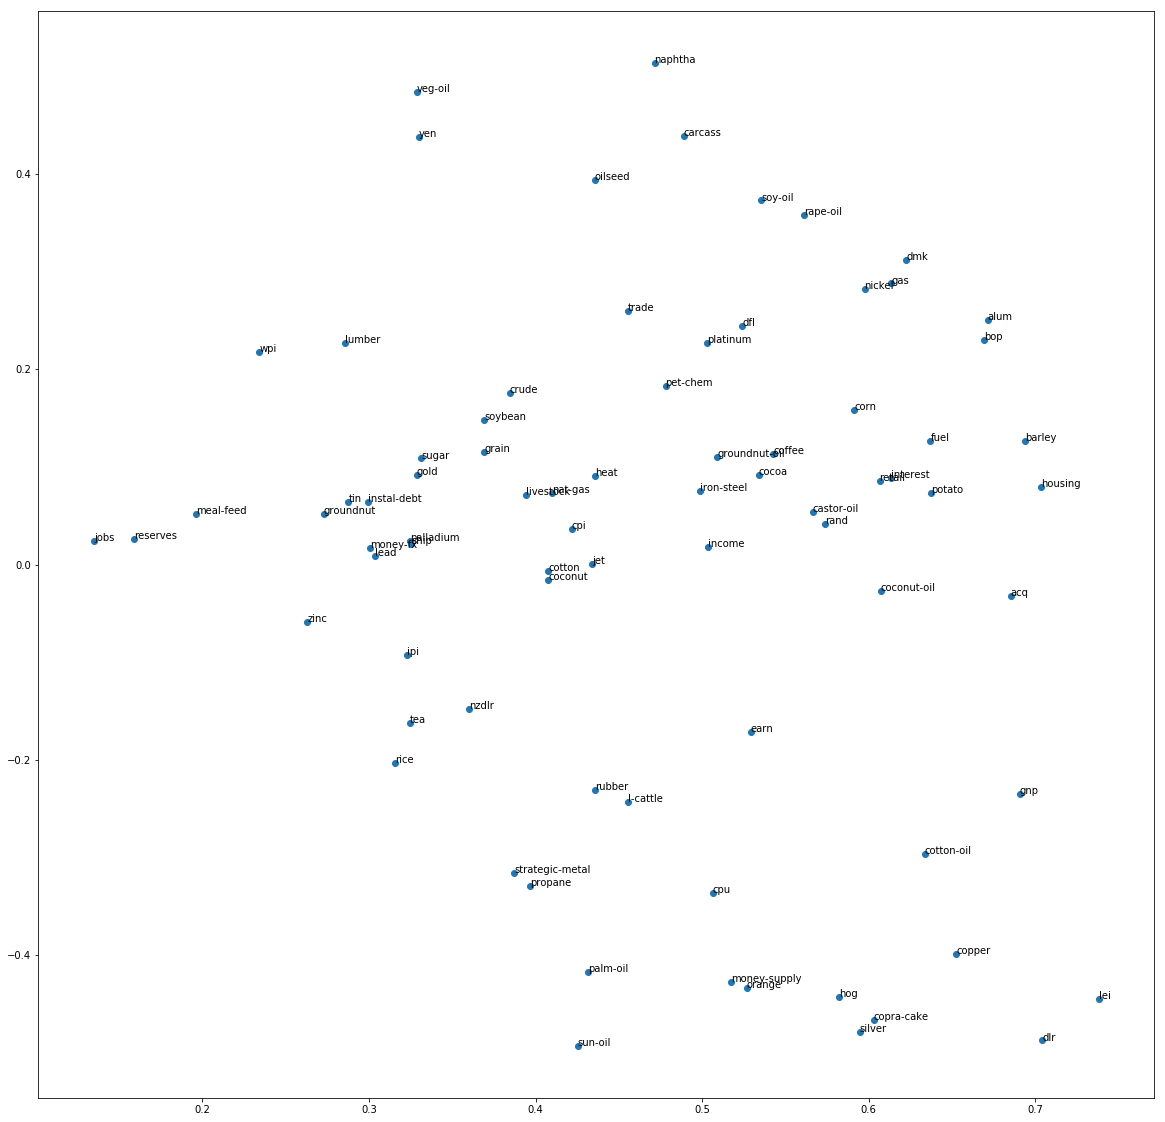

In [216]:
plt.figure(figsize=(20,20))
plt.scatter(ans[:,0],ans[:,1])
for i, txt in enumerate(categories):
    plt.annotate(txt, (ans[i,0],ans[i,1]))